In [1]:
import os
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import sys
import imageio

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [2]:
FILTER = 8

inputs = tf.keras.Input(shape=(256, 256, 3))

b1c1 = layers.Conv2D(FILTER, (3, 3), padding="same", activation="relu")(inputs)
b1c2 = layers.Conv2D(FILTER, (3, 3), padding="same", activation="relu")(b1c1)
rs = layers.Reshape((256, 256, FILTER))(b1c2)
mp1 = layers.MaxPooling2D((4, 4))(rs)

b2c1 = layers.Conv2D(FILTER * 2, (3, 3), padding="same", activation="relu")(mp1)
b2c2 = layers.Conv2D(FILTER * 2, (3, 3), padding="same", activation="relu")(b2c1)
mp2 = layers.MaxPooling2D((4, 4))(b2c2)

b3c1 = layers.Conv2D(FILTER * 4, (3, 3), padding="same", activation="relu")(mp2)
b3c2 = layers.Conv2D(FILTER * 4, (3, 3), padding="same", activation="relu")(b3c1)
mp3 = layers.MaxPooling2D((2, 2))(b3c2)

flat = layers.Flatten()(mp3)
fc1 = layers.Dense(128, activation="relu")(flat)
fc2 = layers.Dense(16, activation="relu")(fc1)
outputs = layers.Dense(1, activation="sigmoid")(fc2)

model = Model(inputs=inputs, outputs=outputs, name="AE")
model.compile(optimizer='adam', loss="binary_crossentropy", metrics = ['binary_accuracy'])

model.summary()

2022-07-16 16:23:38.142355: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-16 16:23:38.259553: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-16 16:23:38.260373: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-16 16:23:38.261612: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "AE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 8)       584       
_________________________________________________________________
reshape (Reshape)            (None, 256, 256, 8)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 16)        2320     

In [ ]:
#plot_model(model, show_shapes=True, show_layer_names=False)

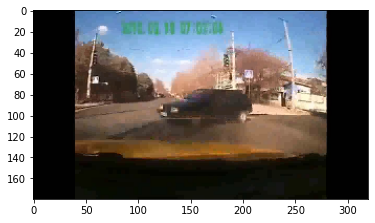

In [3]:
BASE_PATH = "../input/car-crash-dataset-ccd/"#CrashBest/*"
FILENAME = "/C_000001_"
FRAME = "30"
SCALE = 4

img = cv2.imread(BASE_PATH + "CrashBest/" + FILENAME + FRAME + ".jpg")
plt.imshow(img[::SCALE,::SCALE,::-1])

In [4]:
TABLENAME = "../input/car-crash-dataset-ccd/Crash_Table.csv"

df = pd.read_csv(TABLENAME)
#print(df.columns)

arr = []

for ind in df.index:
    for i in range(1, 51):
        arr.append(df[f"frame_{i}"][ind])

print(len(arr))

75000


In [7]:
dataset = keras.preprocessing.image_dataset_from_directory(BASE_PATH, labels=arr, batch_size=128, label_mode='int')

Found 75000 files belonging to 1 classes.


In [8]:
dataset = dataset.map(lambda x, y: (x / 255.0, y))

In [9]:
train_size = int(len(dataset) * 0.8)
train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size)

2022-07-16 16:35:55.871510: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


tf.Tensor(0, shape=(), dtype=int32)


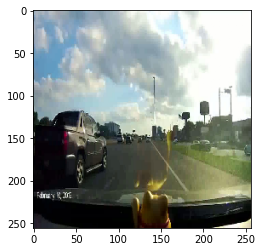

In [10]:
for t in train_ds.take(1):
    plt.imshow(t[0][0])
    print(t[1][0])

In [11]:
model.fit(train_ds, epochs=8, verbose=1, validation_data=test_ds)

Epoch 1/8


2022-07-16 16:36:08.893926: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


468/468 - 740s - loss: 0.5527 - binary_accuracy: 0.7482 - val_loss: 0.5314 - val_binary_accuracy: 0.7627
Epoch 2/8
468/468 - 545s - loss: 0.4879 - binary_accuracy: 0.7818 - val_loss: 0.4590 - val_binary_accuracy: 0.7990
Epoch 3/8
468/468 - 533s - loss: 0.3887 - binary_accuracy: 0.8281 - val_loss: 0.3477 - val_binary_accuracy: 0.8501
Epoch 4/8
468/468 - 532s - loss: 0.2786 - binary_accuracy: 0.8830 - val_loss: 0.2874 - val_binary_accuracy: 0.8794
Epoch 5/8
468/468 - 663s - loss: 0.2008 - binary_accuracy: 0.9209 - val_loss: 0.2494 - val_binary_accuracy: 0.9020
Epoch 6/8
468/468 - 626s - loss: 0.1414 - binary_accuracy: 0.9459 - val_loss: 0.2518 - val_binary_accuracy: 0.9121
Epoch 7/8


KeyboardInterrupt: 

In [12]:
model.save("Acc3.h5")

No crash


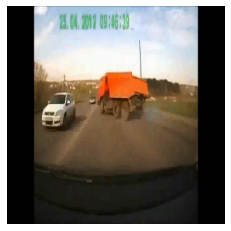

In [22]:
FILENAME = "/C_000002_"
FRAME = "36"

img = cv2.imread(BASE_PATH + "CrashBest/" + FILENAME + FRAME + ".jpg")
img = cv2.resize(img, (256, 256))
plt.axis("off")
plt.imshow(img[:,:,::-1])

crash = model.predict(img.reshape(-1, 256, 256, 3))[0][0]

if crash > 0.5:
    print("Crash")
else:
    print("No crash")

In [ ]:
anim_file = 'test.gif'

imgs = []
filenames = [BASE_PATH + "CrashBest/" + FILENAME + f"{i:02}" + ".jpg" for i in range(1, 51)]
for filename in filenames:
    img = cv2.imread(filename)[::SCALE,::SCALE,::-1]
    imgs.append(img)

    
imgs = [Image.fromarray(img) for img in imgs]
imgs[0].save(anim_file, save_all=True, append_images=imgs[1:], duration=100, loop=0)

In [ ]:
'''images_ds = tf.data.Dataset.list_files(BASE_PATH, shuffle=True)

train_size = int(len(images_ds) * 0.8)
train_ds = images_ds.take(train_size)
test_ds = images_ds.skip(train_size)

for t in images_ds.take(1):
    plt.imshow(process_image(t)[0])

for t in images_ds.take(1):
    plt.imshow(process_image(t)[0])
    
def get_crash(f, v):
    return df[f"frame_{f}"][v - 1]

def get_label(file_path):
    parts = tf.strings.split(file_path, "_")
    vidname = int(parts[1])
    
    f = tf.strings.split(parts[2], ".")
    frame = int(f[0])
    
    #print(vidname.shape, frame)
    
    return 1


def process_image(file_path):
    #print(file_path)
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img)
    img = img / 255
    img = tf.image.resize(img, [256, 256])
    return img, label

img, label = process_image(b'../input/car-crash-dataset-ccd/CrashBest/C_000001_33.jpg')
plt.imshow(img.numpy())
print(type(label))

test = images_ds.map(process_image)
test = test.map(lambda x, y: y)

for t in test.take(1):
    print(t[1])
    
train_ds = train_ds.map(process_image)
test_ds = test_ds.map(process_image)'''